# Careers in gear
## Predict hire / nohire from lead_details.csv

### MLP model with categories encoded onehot


In [8]:
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel('ERROR')

import shutil
import pathlib
import pickle
import itertools

import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer

# from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    average_precision_score
)
# from sklearn import linear_model

from tensorflow.keras import models, layers

# from feature_utils import CategoricalEncoder, DataFrameSelector

from pp_pipeline_utils import (
    splitx,
    DataFrameSelector,
    CategoricalEncoder
)

from metric_utils import (
    plot_precision_recall,
    plot_roc,
    plot_precision_vs_score,
    precision_at_score_percentile,
    precision_by_score_buckets,
    plot_precision_by_score_buckets,
    plot_bucket_counts
)

# from score2ppv import score2ppv, score2ppv_model

In [9]:
np.random.seed(42)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette(sns.color_palette("Set2", 10))

In [11]:
features_file = 'data/cig_features.parq'

In [12]:
features = pd.read_parquet(features_file)

In [13]:
features.sample(5).T

,4522,2499,1413,4357,3830
lead_id,9055365,9337921,1660939,13010742,10484415
form_data_id,438970,454948,230119,1134721,672895
lead_match_client_id,5815,5709,10,11,5817
structured_campaign_name,Martin Resource Management : Regional (Martin ...,Trans System Inc : System Transport Pacific No...,US Xpress : Dedicated : p5 : a13 : M_1140093 (R),K and B Transportation Inc. : otr (OTR 4) : PM...,Ozark : Company Driver : PMC p5 : a1 : M_11350...
company_nicename,Martin Resource Management,System Transport,US Xpress,K&B Transportation,"Ozark Motor Lines, Inc"
full_name,Curtis Hale,Danny Malone,Louis Hubbard,ROBERT TOBAR,Joel Bishop
hired,0,0,1,1,1
city,Longview,Long Beach,Montgomery,Covington,Flat Rock
state,TX,CA,AL,TN,NC
zip,75604,90804,36106,38019,28731


In [14]:
features.hired.sum()

1558

In [15]:
features.hired.sum() / len(features)

0.30471347545472327

In [16]:
def ordinal_keys(s):
    sset = set(s)
    sset.add('')
    return sorted(sset)

In [17]:
category_keys = [
    'driver_type',
    'climate_region'
]

for ck in category_keys:
    features[ck] = features[ck].fillna('')

category_values = {x: ordinal_keys(features[x].unique()) for x in category_keys}
category_lookup = {x:x for x in category_keys}

def get_cat_vals(cat):
    return category_values[category_lookup[cat]]

def make_cat_encoder(atts, encoding='onehot', handle_unknown='ignore'):
    return CategoricalEncoder(encoding=encoding,
                              categories=[get_cat_vals(x) for x in atts],
                              handle_unknown=handle_unknown)

In [18]:
numeric_atts = [
    'exp_yr_num',
    'tickets',
    # rest are boolean
    
    'lease_purchase',
    'drivers_license_class_a',
    'hazmat',
    'tanker',
    'doublestriples',
    'job_alerts',
    'sms_alerts_opt_in',
    'came_from_suggested_job',
    'run_single',
    'run_team',
    'flatbed',
    'van',
    'reefer',
    'multi',
    'oversized',
    'stepdeck',
    'heavy_haul',
    'haul_tanker',
]

category_atts = [
    'driver_type',
    'climate_region'
]

In [19]:
train_set, test_set = train_test_split(features.copy(), test_size=0.2)
len(train_set), len(test_set)

(4090, 1023)

In [20]:
num_pipeline = Pipeline([
    ('num_selector', DataFrameSelector(numeric_atts)),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_selector', DataFrameSelector(category_atts)),
    ('onehot_encoder', make_cat_encoder(category_atts, encoding='onehot', handle_unknown='error'))
])

pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [21]:
%%time
pipeline.fit(train_set)

CPU times: user 14.2 ms, sys: 444 µs, total: 14.6 ms
Wall time: 13 ms


FeatureUnion(n_jobs=None,
             transformer_list=[('num_pipeline',
                                Pipeline(memory=None,
                                         steps=[('num_selector',
                                                 DataFrameSelector(attribute_names=['exp_yr_num',
                                                                                    'tickets',
                                                                                    'lease_purchase',
                                                                                    'drivers_license_class_a',
                                                                                    'hazmat',
                                                                                    'tanker',
                                                                                    'doublestriples',
                                                                                    'job_alerts',
             

In [44]:
X_train = pipeline.transform(train_set).toarray()
y_train = train_set.hired

In [45]:
X_test = pipeline.transform(test_set).toarray()
y_test = test_set.hired

In [46]:
X_train.shape, X_test.shape

((4090, 37), (1023, 37))

In [29]:
n_features = X_train.shape[1]
n_features

37

In [47]:
input = layers.Input(shape=(n_features,))
x = layers.Dense(16, activation='relu')(input)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(input, output)
model.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [48]:
%%time
history = model.fit(X_train, y_train, batch_size=1024, epochs=40,
          class_weight=compute_class_weight('balanced', [0,1], y_train)
         )

Epoch 1/40
4090/4090 [==============================] - 2s 369us/sample - loss: 0.7745
Epoch 2/40
4090/4090 [==============================] - 0s 3us/sample - loss: 0.7339
Epoch 3/40
4090/4090 [==============================] - 0s 3us/sample - loss: 0.7186
Epoch 4/40
4090/4090 [==============================] - 0s 3us/sample - loss: 0.7042
Epoch 5/40
4090/4090 [==============================] - 0s 3us/sample - loss: 0.6785
Epoch 6/40
4090/4090 [==============================] - 0s 3us/sample - loss: 0.6681
Epoch 7/40
4090/4090 [==============================] - 0s 3us/sample - loss: 0.6624
Epoch 8/40
4090/4090 [==============================] - 0s 3us/sample - loss: 0.6576
Epoch 9/40
4090/4090 [==============================] - 0s 3us/sample - loss: 0.6425
Epoch 10/40
4090/4090 [==============================] - 0s 2us/sample - loss: 0.6368
Epoch 11/40
4090/4090 [==============================] - 0s 3us/sample - loss: 0.6350
Epoch 12/40
4090/4090 [==============================] - 0s 3

In [49]:
y_score = model.predict(X_test)

In [50]:
roc_auc_score(y_test, y_score)

0.8092340149302174

In [51]:
average_precision_score(y_test, y_score)

0.6845619575955618

In [52]:
precision_at_score_percentile(y_test, y_score, 90)

0.8155339805825242

In [53]:
precision_at_score_percentile(y_test, y_score, 99)

0.8181818181818182

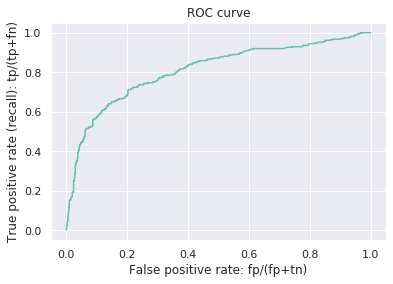

In [54]:
plot_roc(y_test, y_score)

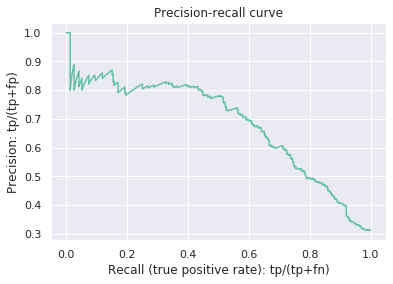

In [55]:
plot_precision_recall(y_test, y_score)

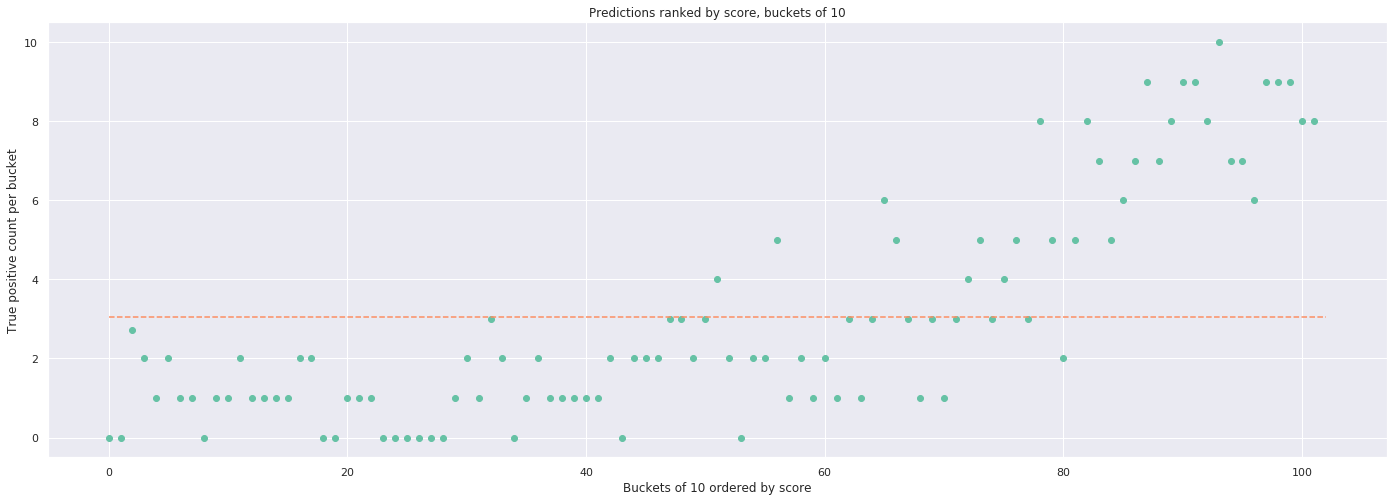

In [56]:
plt.figure(figsize=(24,8))
plot_bucket_counts(y_test, y_score, 10)

In [57]:
# len(test_set)

In [58]:
# len(y_score)

In [59]:
# y_score

In [61]:
# test_set['score'] = y_score

In [ ]:
# test_set.sample(5).T

In [ ]:
# test_set.to_excel('data/cig_test_scored.xlsx', index=False)